# Import Libraries and Files

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

ax.set_ylabel('Example', fontsize=40)

df=pd.read_csv('HS01DataCummulativeNonZeros.csv')
print('Number of rows and columns:', df.shape)
df.head(5)

Variable = 'Gas Volume'

Number of rows and columns: (4012, 6)


In [2]:
df['Time'] = pd.to_datetime(df['Time (Days)'])
df

,Time (Days),Gas Volume,Oil Volume,Water Volume,Gas Production,Oil Production,Time
0,1/1/00,4.4578,0.0000,332.0000,4.4578,0.0000,2000-01-01
1,1/2/00,10.2320,0.0000,482.0000,14.6898,0.0000,2000-01-02
2,1/3/00,11.9070,0.0000,541.0000,26.5968,0.0000,2000-01-03
3,1/4/00,11.7322,0.0000,556.0000,38.3290,0.0000,2000-01-04
4,1/5/00,10.8801,0.0000,538.0000,49.2090,0.0000,2000-01-05
...,...,...,...,...,...,...,...
4007,1/9/11,0.1417,NaN,0.0000,2123.9075,NaN,2011-01-09
4008,1/10/11,0.0646,NaN,0.1400,2123.9721,NaN,2011-01-10
4009,1/11/11,0.1465,NaN,1.0100,2124.1186,NaN,2011-01-11
4010,1/12/11,0.0699,NaN,0.0000,2124.1885,NaN,2011-01-12


In [3]:
stat, p = stats.normaltest(df[Variable])
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')


Statistics=4315.866, p=0.000
Data does not look Gaussian (reject H0)


Kurtosis of normal distribution: 41.39828706492585
Skewness of normal distribution: 5.468583686348641


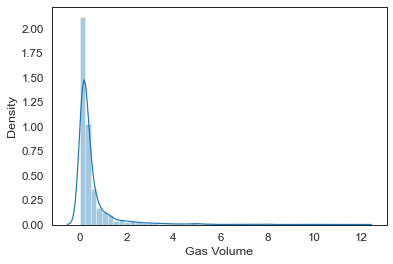

In [4]:
sns.distplot(df[Variable]);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df[Variable])))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df[Variable])))

# First Time Series Plot

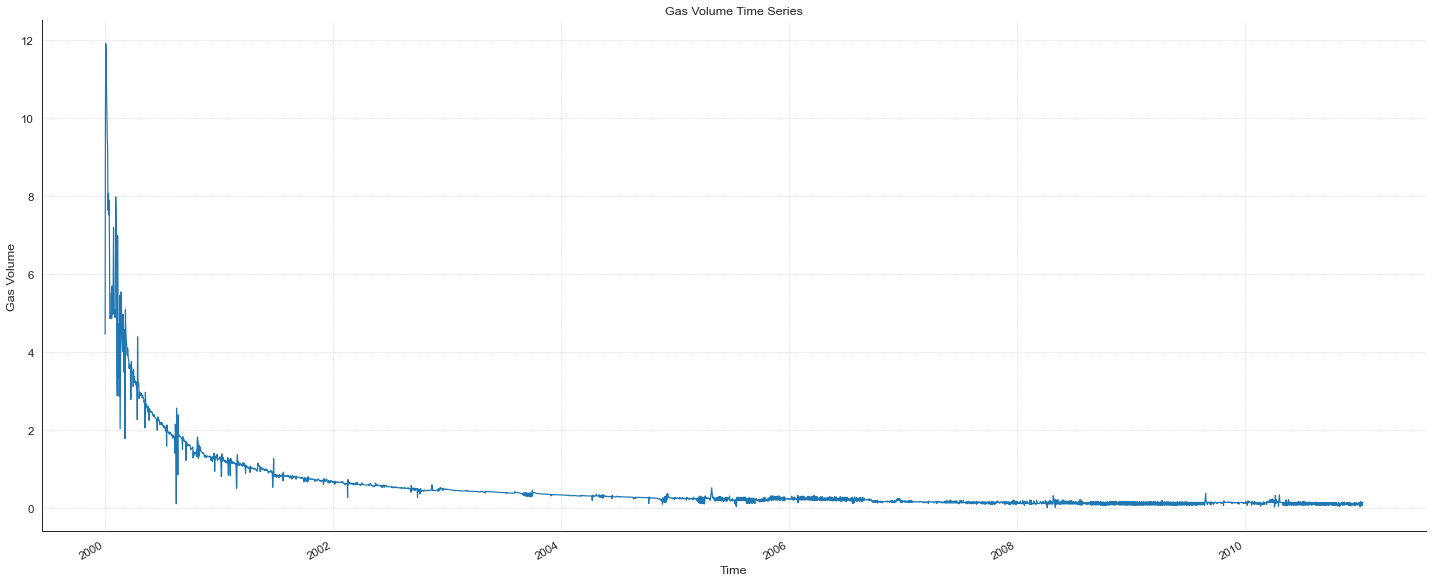

In [5]:
df1=df.loc[:,['Time',Variable]]
df1.set_index('Time',inplace=True)
df1.plot(figsize=(20,8))
plt.ylabel(Variable)
plt.legend().set_visible(False)
plt.tight_layout()
plt.title(Variable + ' Time Series')
sns.despine(top=True)
plt.grid(ls=':')
plt.show();

# Distribution

,count,mean,std,min,25%,50%,75%,max
Gas Volume,4012.0000,0.5295,0.9252,0.0059,0.1461,0.2428,0.4866,11.9070


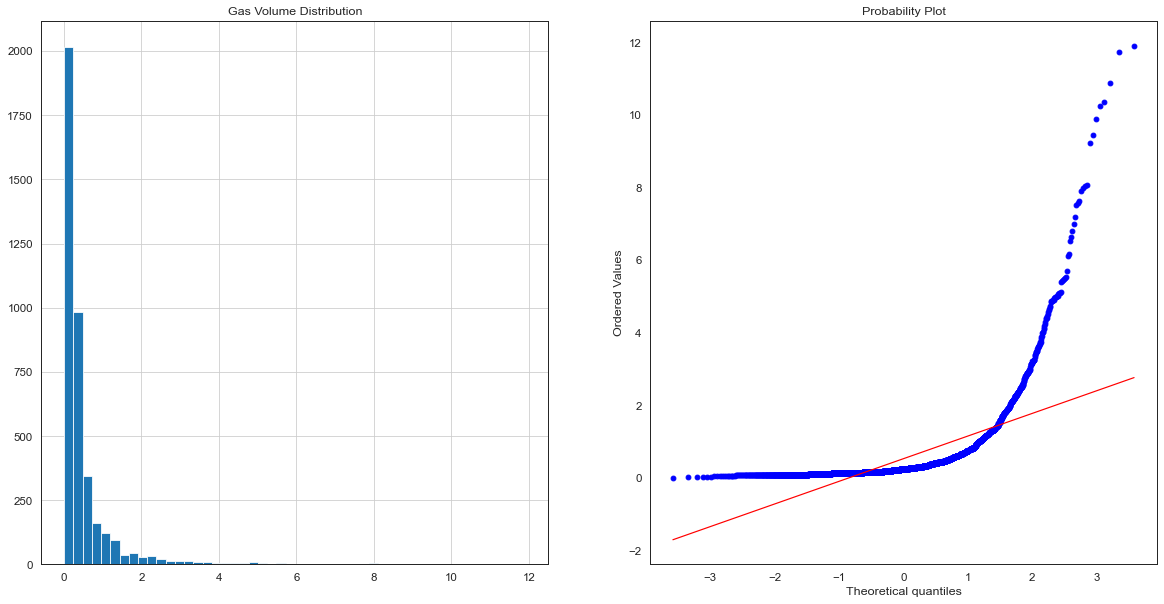

In [6]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
df[Variable].hist(bins=50)
plt.title(Variable + ' Distribution')
plt.subplot(1,2,2)
stats.probplot(df[Variable], plot=plt);
df1.describe().T

# Dickey-Fuller test

* Null Hypothesis (H0): It suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
* Alternate Hypothesis (H1): It suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.
* p-value > 0.05: Accept the null hypothesis (H0), the data has a unit root and is non-stationary.
* p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

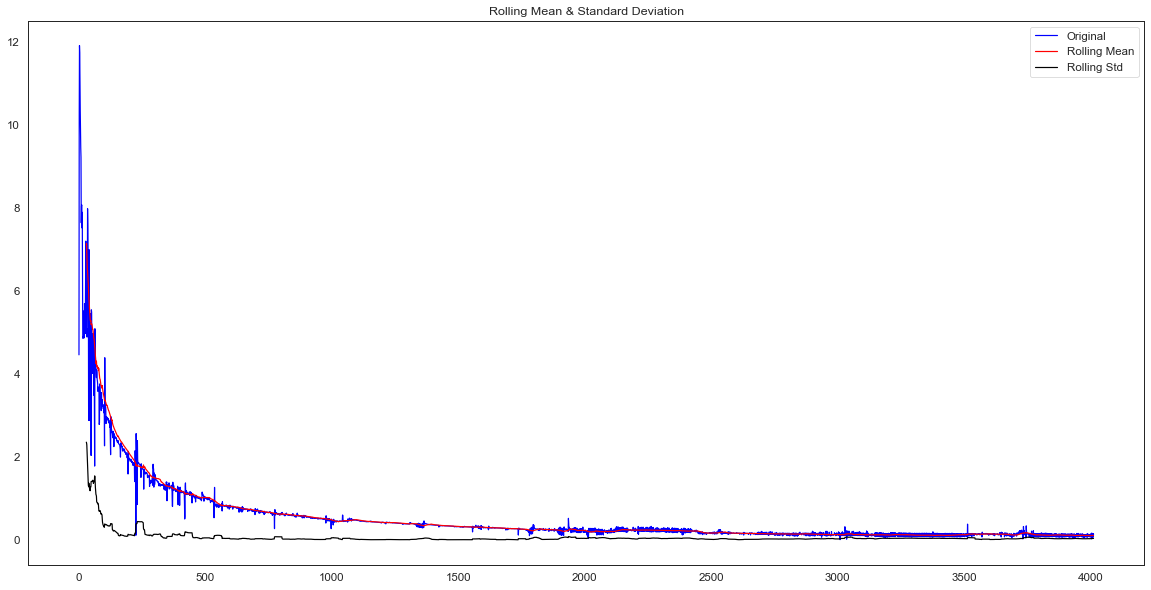

<Results of Dickey-Fuller Test>
Test Statistic                 -24.2126
p-value                          0.0000
#Lags Used                      31.0000
Number of Observations Used   3980.0000
Critical Value (1%)             -3.4320
Critical Value (5%)             -2.8623
Critical Value (10%)            -2.5672
dtype: float64


In [7]:
def test_stationarity(timeseries, window=30):
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()
    
    plt.figure(figsize=(20,10))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(df[Variable].dropna())

# LSTM

* The following data pre-processing and feature engineering need to be done before construct the LSTM model.
* Normalize the features.
* Split into training and test sets.
* Convert an array of values into a dataset matrix.
* Reshape into X=t and Y=t+1.
* Reshape input to be 3D (num_samples, num_timesteps, num_features).

In [8]:
dataset = df[Variable].values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 100

X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [9]:
X_train.shape[2]

100

# Model Architecture

In [10]:
model = Sequential()
model.add(Bidirectional(LSTM(100, return_sequences=True, input_shape=(1, look_back))))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100, return_sequences=False)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='nadam')

history = model.fit(X_train, Y_train, epochs=20, batch_size=128, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

2021-09-20 12:23:01.128980: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-20 12:23:01.503420: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
25/25 [==============================] - 45s 105ms/step - loss: 0.0064 - val_loss: 3.8092e-05
Epoch 2/20
25/25 [==============================] - 1s 20ms/step - loss: 2.5091e-04 - val_loss: 8.7791e-06
Epoch 3/20
25/25 [==============================] - 0s 18ms/step - loss: 7.3397e-04 - val_loss: 8.9274e-06
Epoch 4/20
25/25 [==============================] - 1s 21ms/step - loss: 1.8165e-04 - val_loss: 8.7990e-06
Epoch 5/20
25/25 [==============================] - 0s 20ms/step - loss: 8.7083e-04 - val_loss: 8.7648e-06
Epoch 6/20
25/25 [==============================] - 0s 19ms/step - loss: 3.3313e-04 - val_loss: 8.8470e-06
Epoch 7/20
25/25 [==============================] - 0s 19ms/step - loss: 5.3622e-04 - val_loss: 8.7493e-06
Epoch 8/20
25/25 [==============================] - 0s 20ms/step - loss: 1.8097e-04 - val_loss: 8.8004e-06
Epoch 9/20
25/25 [==============================] - 1s 26ms/step - loss: 3.7148e-04 - val_loss: 8.7681e-06
Epoch 10/20
25/25 [====================

# Make Predictions

In [11]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 0.030012808716334216
Train Root Mean Squared Error: 0.07038285857085551
Test Mean Absolute Error: 0.027986515167300698
Test Root Mean Squared Error: 0.03531320736549252


# Plot Model Loss

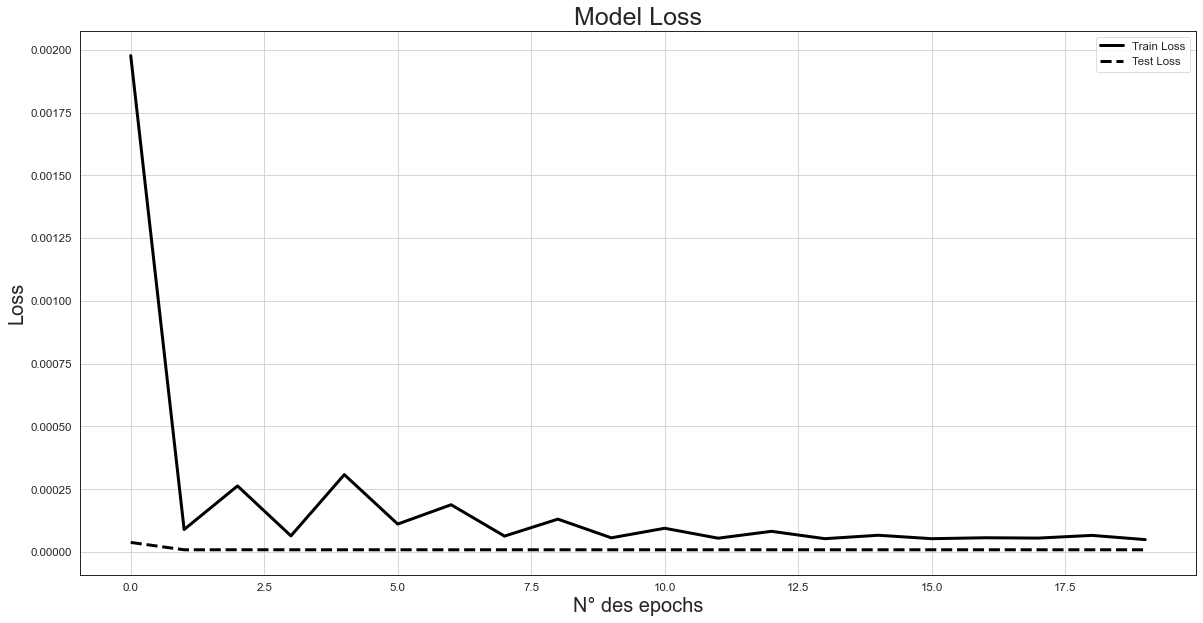

In [21]:
plt.figure(figsize=(20,10))
plt.plot(history.history['loss'], c='k' , label='Train Loss', linewidth=3)
plt.plot(history.history['val_loss'],c='k' , linestyle='--',label='Test Loss', linewidth=3)
plt.title('Model Loss', size=25)
plt.ylabel('Loss', size=20)
plt.xlabel('N° des epochs', size=20)
plt.legend(loc='upper right')
plt.grid()
plt.savefig('ModelLossLSTMHS01.png')
plt.show();

# Compare Actual vs. Prediction

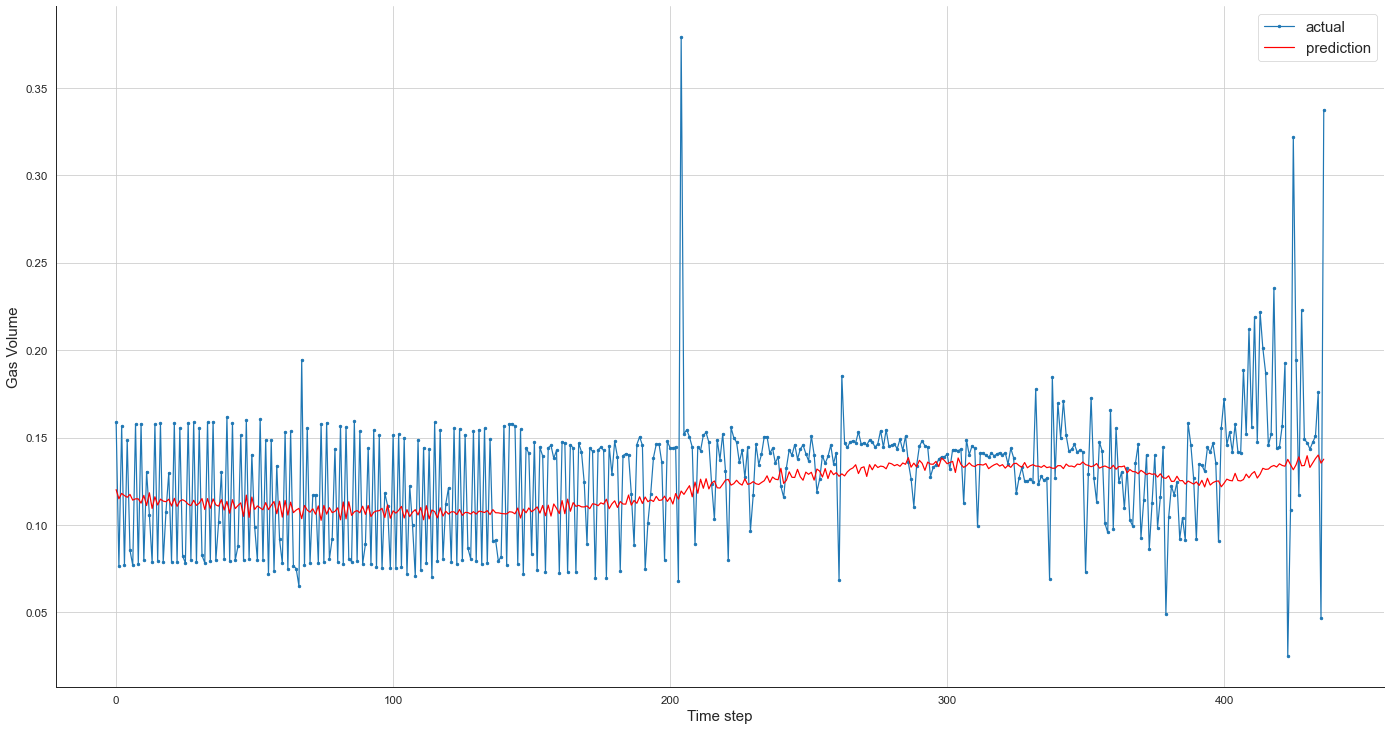

In [13]:
aa=[x for x in range(437)]
plt.figure(figsize=(20,10))
plt.plot(aa, Y_test[0][:437], marker='.', label="actual")
#plt.plot(df['Time (Days)'], df[Variable], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:437], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel(Variable , size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.grid()
plt.savefig('BiLSTMActualVSPredictionHS01.png')
plt.show();